In [1]:
# Theano/Lasagne
import theano
import lasagne
import theano.tensor as T
from lasagne.utils import floatX
from lasagne.layers import *

# numpy/scipy/scikit
import numpy as np
import skimage.transform
import scipy.optimize

# notebook
from nbtools import display_img_array
from IPython.display import clear_output

# for vgg19 model and conv2dlayer
from vgg_model import load_vgg19, ConvLayer

# neural style helper functions
from ns_helpers import prep_image, imread, get_img, Func, Eval, Shared, deprocess

Using gpu device 0: GeForce GTX 980 (CNMeM is enabled with initial size: 75.0% of memory, CuDNN 4007)
/usr/lib/python3.4/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Set some parameters

In [2]:
# Load vgg19 model and set feature layer for neural matching
net = load_vgg19()

# use conv4_1 for neural matching 
feature_layer = net['conv4_1']
compute_matching_features = theano.function([net['input'].input_var], [get_output(feature_layer)])


Use conv to find nearest neighbor of a patch

In [3]:
# builder of best_match
# not using lru_cache because of python 2.7 compatibility
def build_best_match(C, psize, num_patches, input_img, mem={}):
    key = (C, psize, num_patches)
    if key not in mem:
        # compute norm
        #input_img = T.tensor4()
        layer_img = InputLayer((1, C, None, None), input_var=input_img)
        layer_sqr_sum = ExpressionLayer(layer_img,  lambda x:T.sum(T.sqr(x), axis=1,keepdims=True) , output_shape=(1,1,None,None))
        layer_norm = ConvLayer(layer_sqr_sum, 1, psize, pad='valid', W=floatX(np.ones((1, 1, psize,psize))), b=None, nonlinearity=T.sqrt)
        layer_norm_reshape = ReshapeLayer(layer_norm, ([2], [3]))
        # compute correlation
        input_patch = T.tensor4()
        patch_sqr_sum = (input_patch**2).sum(axis=3).sum(axis=2).sum(axis=1).reshape((1, num_patches, 1, 1))
        layer_prod= ConvLayer(layer_img, num_patches, psize, pad='valid', W=input_patch, b=None, nonlinearity=None)
        layer_corr = ElemwiseMergeLayer([layer_prod, layer_norm_reshape], lambda a,b: (a/b)/patch_sqr_sum)
        layer_corr_output = lasagne.layers.get_output(layer_corr)
        # Pack into a function to find the Nearest Neighbor        
        mem[key] = theano.function([input_patch], T.max_and_argmax(layer_corr_output, axis=(2,3))+[T.shape(layer_corr_output)])
    return mem[key]

Scan through the content image, for each PSIZExPSIZE patch in the content image, and find the best match(nearest neighbor) in style image

In [4]:
def match_all(photo_feature, style_feature, IMAGE_H, IMAGE_W, PSIZE):
    # there are H rows of patches and W patches at each row.    
    H = photo_feature.shape[2]-PSIZE+1
    W = style_feature.shape[3] - PSIZE+1
    C = feature_layer.num_filters

    # build the best_match routine
    input_img = Shared(("match_input_img"), style_feature)
    best_match = build_best_match(C, PSIZE, W, input_img)

    # set up arrays for input patches and output results
    patches = np.zeros( shape=(W, photo_feature.shape[1], PSIZE, PSIZE) ,  dtype= photo_feature.dtype)
    mapping_idx = np.zeros((H,W), dtype='int64')
    mapping_weight = np.zeros((H,W), dtype='float32')

    # doing the match row by row
    for j in range(H):
        for n in range(W):            
                patches[n] = photo_feature[0, :, j:j+PSIZE,n:n+PSIZE ]  
        m, idx, s = best_match(patches)
        mapping_idx[j] =idx
        mapping_weight[j] = (m+1)**2  # making the weight positive in a some what arbitrary way    
    return mapping_idx, mapping_weight

In [5]:
def plot_match_result(mapping_idx, mapping_weight, raw_style, psize, method):
    assert mapping_idx.shape == mapping_weight.shape
    assert method in ('max', 'average')
    H, W = mapping_idx.shape
    S = raw_style.shape[1]//(W+psize-1)
    preview = np.zeros(raw_style.shape)
    preview_weight = np.zeros(raw_style.shape)
    for j in range(H):
        for n in range(W):
            y,x = np.unravel_index(mapping_idx[j,n], mapping_idx.shape)
            _preview = preview[j*S:(j+psize)*S, n*S:(n+psize)*S]
            _preview_weight = preview_weight[j*S:(j+psize)*S, n*S:(n+psize)*S]  
            if method == 'max':
                _preview[...] = np.where(_preview_weight < mapping_weight[j,n], raw_style[y*S:(y+psize)*S, x*S:(x+psize)*S], _preview)        
                _preview_weight[...]=np.where(_preview_weight < mapping_weight[j,n], mapping_weight[j,n], _preview_weight)
            else:
                _preview[...] += mapping_weight[j,n]*raw_style[y*S:(y+psize)*S, x*S:(x+psize)*S]
                _preview_weight[...] += mapping_weight[j,n]
    print(preview_weight.min())
    if method == 'average':
        preview /= preview_weight
    return preview

In [6]:
def plot_match_result_with_a2(mapping_idx, mapping_weight, raw_style, psize, method):
    assert mapping_idx.shape == mapping_weight.shape
    assert method in ('max', 'average')
    H, W = mapping_idx.shape
    S = raw_style.shape[2]//(H+psize-1)
    preview = np.zeros(raw_style.shape)
    a2 = np.zeros(raw_style.shape)
    preview_weight = np.zeros(raw_style.shape)
    for j in range(H):
        for n in range(W):
            y,x = np.unravel_index(mapping_idx[j,n], mapping_idx.shape)
            _preview = preview[:,:,j*S:(j+psize)*S, n*S:(n+psize)*S]
            _preview_weight = preview_weight[:,:,j*S:(j+psize)*S, n*S:(n+psize)*S]  
            _a2 = a2[:,:,j*S:(j+psize)*S, n*S:(n+psize)*S] 
            w = mapping_weight[j,n]
            if method == 'max':
                _preview[...] = np.where(_preview_weight < w, raw_style[:,:,y*S:(y+psize)*S, x*S:(x+psize)*S], _preview)        
                _preview_weight[...]=np.where(_preview_weight < w, w, _preview_weight)
                _a2 = np.where(_preview_weight < w, raw_style[:,:,y*S:(y+psize)*S, x*S:(x+psize)*S]**2,_a2)
            else:
                _preview[...] += w*raw_style[:,:,y*S:(y+psize)*S, x*S:(x+psize)*S]
                _preview_weight[...] += w
                _a2 += w * raw_style[:,:,y*S:(y+psize)*S, x*S:(x+psize)*S]**2
    if method == 'average':
        preview /= preview_weight
        a2 /= preview_weight
    return preview, a2

Set and load content image and style image

In [7]:
img0 = imread("CNNMRF/data/content/0.jpg")
img1 = imread("CNNMRF/data/style//0.jpg")
imgh, imgw = img0.shape[:2]
imgh,imgw = 384, 384*imgw//imgh

im.shape (384, 259, 3)
im.shape2 (384, 259, 3)
im.shape (384, 269, 3)
im.shape2 (384, 259, 3)


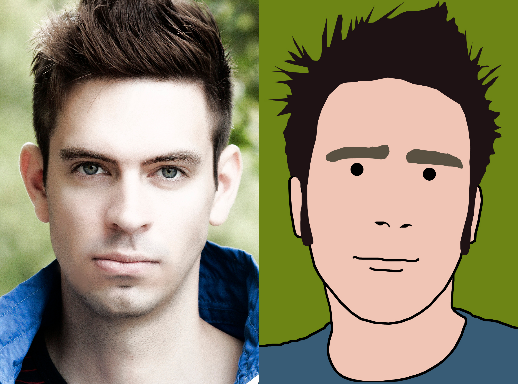

In [8]:
display_img_array(np.hstack([prep_image(img0, imgw, imgh)[0], prep_image(img1, imgw, imgh)[0]]))

## Neural Style transformation

set content layers and style layers

In [9]:
content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
style_layers = ['conv4_1']
layers = {k: net[k] for k in content_layers+style_layers}

basic norm and loss functions

In [10]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g

def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    loss = 1./2 * lasagne.objectives.squared_error(x, p).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)).sum()

In [11]:
def style_loss(A, A2, X, layer):    
    a = A[layer]
    a2 = A2[layer]
    x = X[layer]
    s = x.shape.eval()
    loss = (x**2).sum()+a2-2*(x*a).sum()
    return loss

In [ ]:
def transfer(img0, img1, IMAGE_H, IMAGE_W, PSIZE, init_img=None):
    # prepare content and style
    raw_content, content = prep_image(get_img(img0), IMAGE_W, IMAGE_H)
    print("content", content.shape)
    raw_style, style = prep_image(get_img(img1), IMAGE_W, IMAGE_H)
    #input_image = Shared((IMAGE_H, IMAGE_W, "input"), style)
    input_image = Shared(("input_image"), style)
    outputs = lasagne.layers.get_output(layers.values(), input_image)
    input_image.set_value(style)
    style_features = {k: Shared(("style_"+k), Eval((k), output)) for k, output in zip(layers.keys(), outputs)}
    input_image.set_value(content)
    content_features = {k: Shared(("content_"+k), Eval((k), output)) for k, output in zip(layers.keys(), outputs)}
    # prepare gen_features    
    generated_image = input_image
    if init_img is not None:
        raw_init, init = prep_image(init_img, IMAGE_W, IMAGE_H)
        generated_image.set_value(init)        
    else:
        generated_image.set_value(content)
    gen_features = {k: v for k, v in zip(layers.keys(), outputs)}   
    x0 = input_image.get_value()
    dx0 = deprocess(x0)
    x0_feature = floatX(compute_matching_features(x0)[0])
    style_feature = floatX(compute_matching_features(style)[0])
    display_img_array(dx0)
    
    # prepare inital mapping
    mapping_idx, mapping_weight = match_all(x0_feature, style_feature, IMAGE_H, IMAGE_W, PSIZE)
    style_a = {}
    style_a2 = {}
    for k,a in style_features.items():
        npa = np.array(a.eval())
        npA, A2 = plot_match_result_with_a2(mapping_idx, mapping_weight, npa, PSIZE, "average")
        style_a[k] = Shared(('A_'+k), floatX(npA))
        style_a2[k] = Shared(('A2_'+k), floatX(A2.sum())) 
    tv_loss = 0.1e-3 * total_variation_loss(generated_image) 
    c_loss = 0.
    for layer in content_layers:
           c_loss += 7 * content_loss(content_features, gen_features, layer)
    s_loss = 0.
    for layer in style_layers:
            s_loss += 10 * style_loss(style_a, style_a2,  gen_features, layer)
    total_loss = tv_loss + c_loss+ s_loss
    f_errors = Func(('errors'), [], [tv_loss, c_loss, s_loss])
    grad = T.grad(total_loss, generated_image)
    # Theano functions to evaluate loss and gradient
    f_loss = Func(("loss"), [], total_loss)        
    f_grad = Func(("grad"), [], grad)        
    x0 = generated_image.get_value().astype('float64')
    
    def eval_loss(x0):
        x0 = floatX(x0.reshape((1, 3, IMAGE_H, IMAGE_W)))
        generated_image.set_value(x0)
        x0_feature = floatX(compute_matching_features(x0)[0])
        mapping_idx, mapping_weight = match_all(x0_feature, style_feature, IMAGE_H, IMAGE_W, PSIZE)
        for k,a in style_features.items():
                npa = np.array(a.eval())
                npA, A2 = plot_match_result_with_a2(mapping_idx, mapping_weight, npa, PSIZE, "average")
                Shared(('A_'+k), floatX(npA))
                Shared(('A2_'+k), floatX(A2.sum())) 
        return f_loss().astype('float64')

    def eval_grad(x0):    
        return np.array(f_grad()).flatten().astype('float64')
    
    for i in range(10):
        x, loss, d = scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=200)    
        x0 = generated_image.get_value()   
        errors = [float(x) for x in f_errors()]        
        print(i, loss, errors)
        dx0 = deprocess(x0)
        display_img_array(dx0)
    return dx0
    


im.shape (96, 64, 3)
im.shape2 (96, 64, 3)
content (1, 3, 96, 64)
im.shape (96, 67, 3)
im.shape2 (96, 64, 3)


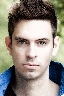

0 215457.1875 [2887.7080078125, 114566.90625, 98002.578125]


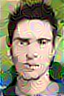

1 212055.875 [2792.8662109375, 116840.828125, 92422.1875]


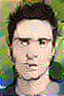

2 211169.71875 [2764.022705078125, 116756.9375, 91648.75]


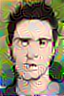

3 210872.28125 [2742.959228515625, 116984.78125, 91144.53125]


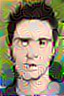

4 210726.3125 [2739.2490234375, 117090.65625, 90896.40625]


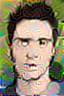

In [ ]:
dx = transfer(img0, img1, imgh//4, imgw//4, 3)
dx = transfer(img0, img1, imgh//2, imgw//2, 3, init_img=dx)
dx = transfer(img0, img1, imgh, imgw, 3, init_img=dx)

In [ ]:
dx = transfer(img1, img0, imgh//4, imgw//4, 3)
dx = transfer(img1, img0, imgh//2, imgw//2, 3, init_img=dx)
dx = transfer(img1, img0, imgh, imgw, 3, init_img=dx)

In [ ]:
img2 = imread("CNNMRF/data/content/potrait1.jpg")
img3 = imread("CNNMRF/data/style/picasso.jpg")
imgh, imgw = img2.shape[:2]
dx = transfer(img2, img3, imgh//4, imgw//4, 3)
dx = transfer(img2, img3, imgh//2, imgw//2, 3, init_img=dx)
dx = transfer(img2, img3, imgh, imgw, 3, init_img=dx)

In [ ]:
img2 = imread("CNNMRF/data/content/d.jpg")
img3 = imread("CNNMRF/data/style/d.jpg")
imgh, imgw = img2.shape[:2]
dx = transfer(img2, img3, imgh//4, imgw//4, 3)
dx = transfer(img2, img3, imgh//2, imgw//2, 3, init_img=dx)
dx = transfer(img2, img3, imgh, imgw, 3, init_img=dx)